In [1]:
from utils.card_engine import Card_Game, Card_Env, random_agent

In [2]:
import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from itertools import count



# global game gym
env = Card_Env()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Replay Memory

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# Q network

In [4]:
class DQN(nn.Module):

    # n_input: the current state
    #  (1x52)    +  (56x52)       +       (1x52): the current state
    #    ^hand       ^who plays each card  ^cards not seen yet
    #                       + cards played
    # n_output: probability of playing each card
    #   (1x52)
    def __init__(self, n_input, n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_output)

    def forward(self, x):
        if x.dtype == torch.float32:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        else:
            x=x.to(torch.float32)
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        return self.layer3(x)

# Training

### The network agent
Selects a move according to epsilon-greedy policy:
sometimes uses the model to select move, sometimes just select one randomally

In [5]:
# hyper-parameters
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

# I am making batch_size small here so that we can test if this goes through in shorter time
BATCH_SIZE = 3
MEMORY_SIZE = 10000

# Learning rate of the optimizer
LR = 1e-4

# soft update rate
TAU = 0.005

# future discount
GAMMA = 1.0


state = env.game.get_network_input()

n_input = len(state)
n_actions = 52

policy_net = DQN(n_input, n_actions).to(device)
# use a target network to prevent oscillation or divergence
target_net = DQN(n_input, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0

'''
Given the game state, select an action by the epsilon-greedy policy
'''
def select_action(game):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # epsilon-greedy choice
        
    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the card with highest probability
            # predicted from the policy net
            print(policy_net(game.get_network_input().to(torch.float32).to(device)))
            return policy_net(game.get_network_input().to(torch.float32).to(device)).max(0).indices.view(1,1)
    else:
        # random select a legal action
        return torch.tensor([[game.sample_legal_move()]], device=device, dtype=torch.long) #changed from long



### Training loop

In [6]:
'''
A single step optimization of the model using Deep Q-Learning
1) samples a batch from memory, concatenates all the tensors into a single one
2) computes Q(s_t, a_t) and V(s_{t+1}) = max_a Q(s_{t+1}, a), where s_t --(a_t)--> s_{t+1}
3) computes the loss
4) updates the target network (which is computing V(s_{t+1})) at every step with soft update
'''
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # mask the non final states and find the corresponding next states
    # We need an illegal move to be a non-final state
    # Right now, we are throwing out all the final states which include the case when
    # the agent ends the game prematurely after playing an illegal move
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    print('non_final_mask is', non_final_mask)
    non_final_next_states = [s for s in batch.next_state if s is not None]
    if non_final_next_states == []:
        return
    non_final_next_states = torch.cat(non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    print('reward_batch is', reward_batch)
    
    
    # compute Q(s_t, a)
    # for each state in the batch, find the value of the corresponding action
    state_action_values = policy_net(state_batch.to(torch.float)).gather(1, action_batch)
    # compute V(s_{t+1}) = max_a Q(s_{t+1}, a) for the next_states using the target_net
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # R + \gamma max_a Q(s', a)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # back propagate
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [7]:
# the main training loop
step_counts = []

if device != torch.device('cpu'):
    num_episodes = 1000
else:
    num_episodes = 100

for i_episode in range(num_episodes):
    # initialize the game
    env.reset()
    game = env.game
    state = torch.tensor(game.get_network_input(), dtype=torch.long, device=device).unsqueeze(0)
    #print('i_episode is', i_episode)

    for t in count():
        #print('t is ', t)
        # play until the game ends
        if game.hands[game.current_player].sum(0) != 0:
            print("Hand:", game.hands[game.current_player])
            action = select_action(game)
            print("Card:", action)
            observation, reward, terminated = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated
        else:
            terminated = True
            done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        print('the transition tuple being pushed into memory is', (state,action,next_state,reward))
        # store the transition in memory
        memory.push(state, action, next_state, reward)

        # move to the next state
        state = next_state

        # perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)


        if done:
            print(f'{i_episode}-th game ends in {t} steps')
            step_counts.append(t)
            break
        


C:\Users\Shin\AppData\Local\Temp\ipykernel_8808\1847103997.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(game.get_network_input(), dtype=torch.long, device=device).unsqueeze(0)
C:\Users\Shin\Documents\dqn-trick-game\utils\card_engine.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  card = torch.nn.functional.one_hot(torch.tensor(deck_index, dtype=int), self.num_cards * self.num_players).flatten()
C:\Users\Shin\AppData\Local\Temp\ipykernel_8808\1847103997.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  

Hand: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0])
Card: tensor([[4]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 0,  ..., 0, 1, 1]]), tensor([[4]]), tensor([[0., 0., 0.,  ..., 0., 1., 1.]]), tensor([0]))
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0])
Card: tensor([[8]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 1., 1.]]), tensor([[8]]), ten

the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([[47]]), tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([0]))
non_final_mask is tensor([ True,  True, False])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0])
tensor([ 0.1001, -0.0097, -0.0775, -0.0172, -0.0467, -0.0767, -0.0806, -0.0387,
        -0.0660, -0.0040,  0.0342,  0.0324,  0.0726,  0.0876,  0.0408,  0.0472,
        -0.0213, -0.0029,  0.0760,  0.0437,  0.0116,  0.0782, -0.0828,  0.0131,
        -0.0116, -0.0268, -0.0813,  0.0020, -0.0010,  0.0447, -0.0369, -0.0066,
        -0.0875,  0.0242, -0.0006,  0.0610,  0.0168,  0.0241,  0.1273, -0.0470,
         0.0377,  0.0938,  0.0352, -0.0325, -0.0115, -0.0744, -0.0

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[47]])
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[47]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 1., 1.]])
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[47]]), None, tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])
2-th game ends in 13 steps
Hand: tensor([0, 0, 1, 0, 0, 1,

Hand: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 0])
Card: tensor([[23]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 1., 0., 1.]]), tensor([[23]]), tensor([[0., 0., 0.,  ..., 1., 0., 1.]]), tensor([0]))
non_final_mask is tensor([ True, False, False])
state_batch is tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
Hand: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 0])
Card: tensor([[41]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is p

player tensor(2) is playing
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[28]]), None, tensor([0]))
non_final_mask is tensor([ True, False,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.]])
7-th game ends in 7 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0])
Card: tensor([[27]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 0,  ..., 1, 1, 1]]), tensor([[27]]), tensor([[0., 0., 0.,  ..., 1., 1., 1.]]), tensor([0]))
non_final_mask is tensor([False, False,  True])
state_

player tensor(2) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[33]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[28]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[28]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), ten

10-th game ends in 10 steps
Hand: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0])
Card: tensor([[29]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[1, 1, 0,  ..., 1, 1, 1]]), tensor([[29]]), tensor([[1., 1., 0.,  ..., 1., 1., 1.]]), tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
Hand: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0])
Card: tensor([[39]])

13-th game ends in 1 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1])
Card: tensor([[11]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 1,  ..., 1, 1, 0]]), tensor([[11]]), tensor([[0., 0., 1.,  ..., 1., 1., 0.]]), tensor([0]))
non_final_mask is tensor([ True, False,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1])
tensor([ 0.0825, -0.0256, -0.0827, -0.0044, -0.0266, -0.0560, -0.0822,  0.0021,
        -0.0179,  0.0193,

Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1])
Card: tensor([[8]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[1., 0., 0.,  ..., 0., 0., 0.]]), tensor([[8]]), tensor([[1., 0., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is tensor([ True, False,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.]])
Hand: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1])
Card: tensor([[0]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is play

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 0])
Card: tensor([[50]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([[50]]), tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[1., 0., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 1.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0])
Card: tensor([[45]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is p

player tensor(3) is playing
player tensor(1) is playing
the transition tuple being pushed into memory is (tensor([[0., 1., 1.,  ..., 1., 1., 1.]]), tensor([[21]]), None, tensor([0]))
non_final_mask is tensor([ True,  True, False])
state_batch is tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.]])
26-th game ends in 2 steps
Hand: tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0])
Card: tensor([[48]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 1,  ..., 1, 1, 1]]), tensor([[48]]), tensor([[0., 0., 1.,  ..., 1., 1., 0.]]), tensor([0]))
non_final_mask is tensor([True, True, True])
state_ba

player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 1., 0., 1.]]), tensor([[42]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[24]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[24]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), ten

Hand: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0])
tensor([ 0.0721, -0.0322, -0.0647,  0.0062, -0.0490, -0.0919, -0.0783, -0.0141,
        -0.0135,  0.0106,  0.0395,  0.0262,  0.0749,  0.0779,  0.0674,  0.0743,
        -0.0235,  0.0370,  0.0721,  0.0250,  0.0489,  0.0911, -0.0324,  0.0504,
        -0.0136, -0.0028, -0.0561,  0.0256,  0.0161,  0.0634, -0.0175,  0.0249,
        -0.0985,  0.0656,  0.0363,  0.0687,  0.0382,  0.0504,  0.0744, -0.0297,
         0.0843,  0.0538,  0.0432, -0.0095,  0.0055, -0.0800,  0.0088,  0.1065,
         0.0589,  0.0048, -0.0586, -0.0198])
Card: tensor([[47]])
player plays an illegal move
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 1., 1.]]), tensor([[47]]), None, tensor([-10]))
non_final_mask is tensor([True, True, True])
state_batch is tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [

Hand: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0])
Card: tensor([[5]])
player tensor(1) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([[5]]), tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([0]))
non_final_mask is tensor([True, True, True])
state_batch is tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 1., 0., 1.]])
Hand: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0])
tensor([ 0.0365, -0.0096, -0.0380,  0.0214, -0.0489, -0.0730, -0.0844, -0.0063,
        -0.0101, -0.0095,  0.0617,  0.0809,  0.0551,  0.0638,  0.0870,  0.0796,
        -0.0212,  0.0256,  

Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0])
Card: tensor([[14]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([[14]]), tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 1., 1.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0])
tensor([ 3.5937e-02, -4.7491e-03, -2.5955e-02,  1.3252e-03, -3.8176e-02,
        -6.7010e-02, -6.6971e-02, -1.9152e-02, -1.082

state_batch is tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
43-th game ends in 10 steps
Hand: tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0])
Card: tensor([[16]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 1,  ..., 0, 1, 1]]), tensor([[16]]), tensor([[0., 0., 1.,  ..., 0., 1., 1.]]), tensor([0]))
non_final_mask is tensor([ True, False,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 1., 0., 1.]])
Hand: tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0,

player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[19]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is tensor([True, True, True])
state_batch is tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 1., 0., 1.]])
Hand: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[47]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[47]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is ten

state_batch is tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 1., 0., 1.]])
Hand: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0])
Card: tensor([[38]])
player tensor(1) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[1., 1., 0.,  ..., 0., 0., 0.]]), tensor([[38]]), tensor([[1., 1., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is tensor([ True,  True, False])
state_batch is tensor([[0., 0., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Hand: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0])
Card: tensor([[48]

53-th game ends in 1 steps
Hand: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
Card: tensor([[32]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 1,  ..., 1, 1, 1]]), tensor([[32]]), tensor([[0., 0., 1.,  ..., 1., 1., 1.]]), tensor([0]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [1., 1., 0.,  ..., 0., 1., 1.]])
Hand: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])
tensor([ 0.0319,  0.0

the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 1., 1.]]), tensor([[47]]), tensor([[0., 0., 0.,  ..., 0., 0., 1.]]), tensor([0]))
non_final_mask is tensor([ True, False,  True])
state_batch is tensor([[1., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0])
tensor([ 0.0372,  0.0190,  0.0107,  0.0094, -0.0364, -0.0681, -0.0670,  0.0086,
        -0.0124, -0.0072,  0.0717,  0.0655,  0.0128,  0.0557,  0.0774,  0.0556,
        -0.0018,  0.0224,  0.0918,  0.0672,  0.0450,  0.0526, -0.0143,  0.0840,
        -0.0022,  0.0054, -0.0363,  0.0348,  0.0486,  0.0705,  0.0130,  0.0185,
        -0.0971,  0.0889,  0.0752,  0.0523,  0.0536,  0.0892,  0.0783,  0.0178,
         0.0565,  0.0388,  0.0874, -0.0552,  0.0433, -0.0475,  0.0

Hand: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1])
tensor([ 0.0476,  0.0268, -0.0156, -0.0197, -0.0548, -0.0695, -0.0632, -0.0013,
         0.0039,  0.0267,  0.0720,  0.0717,  0.0059,  0.0635,  0.0665,  0.0814,
        -0.0041,  0.0106,  0.0682,  0.0850,  0.0701,  0.0330, -0.0180,  0.0764,
         0.0164, -0.0108, -0.0144,  0.0455,  0.0324,  0.1018,  0.0197,  0.0128,
        -0.1142,  0.1137,  0.0786,  0.0556,  0.0671,  0.0770,  0.0378,  0.0261,
         0.0547,  0.0172,  0.0959, -0.0443,  0.0735, -0.0266,  0.0583, -0.0063,
         0.0724, -0.1150, -0.0252, -0.0801])
Card: tensor([[33]])
player plays an illegal move
the transition tuple being pushed into memory is (tensor([[0., 1., 1.,  ..., 1., 1., 0.]]), tensor([[33]]), None, tensor([-10]))
non_final_mask is tensor([False,  True, False])
state_batch is tensor([[0., 0., 0.,  ..., 1., 1., 1.],
      

Hand: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0])
tensor([-0.0200,  0.0456, -0.0034, -0.0176, -0.0450, -0.0511, -0.0530, -0.0159,
         0.0309,  0.0495,  0.0990,  0.0747, -0.0152,  0.0776,  0.0960,  0.1059,
        -0.0139,  0.0345,  0.0287,  0.1188,  0.0911, -0.0023,  0.0076,  0.0933,
         0.0131,  0.0144,  0.0024,  0.0504,  0.0550,  0.0822,  0.0262,  0.0265,
        -0.1129,  0.1231,  0.1239,  0.0436,  0.0898,  0.0575,  0.0299,  0.0158,
         0.0772, -0.0377,  0.0911, -0.0079,  0.0972, -0.0163,  0.0773, -0.0947,
         0.0598, -0.1437,  0.0045, -0.1490])
Card: tensor([[34]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 1., 1.]]), tensor(

tensor([-0.0030,  0.0444,  0.0143, -0.0324, -0.0510, -0.0348, -0.0615,  0.0037,
         0.0118,  0.0466,  0.0956,  0.0580, -0.0258,  0.0804,  0.0821,  0.1145,
         0.0005,  0.0289,  0.0501,  0.1131,  0.0971, -0.0222,  0.0175,  0.0852,
         0.0221,  0.0101, -0.0155,  0.0699,  0.0702,  0.0840,  0.0381,  0.0441,
        -0.0985,  0.1188,  0.1230,  0.0322,  0.0727,  0.0416,  0.0012,  0.0184,
         0.0593, -0.0340,  0.1008, -0.0283,  0.0789, -0.0003,  0.1068, -0.1132,
         0.0718, -0.1501, -0.0055, -0.1434])
Card: tensor([[34]])
player plays an illegal move
the transition tuple being pushed into memory is (tensor([[0, 1, 0,  ..., 1, 0, 1]]), tensor([[34]]), None, tensor([-10]))
non_final_mask is tensor([True, True, True])
state_batch is tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.]])
70-th game ends in 0 steps
Hand: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        

73-th game ends in 7 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1])
Card: tensor([[16]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 0,  ..., 0, 1, 0]]), tensor([[16]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0]))
non_final_mask is tensor([ True, False,  True])
state_batch is tensor([[0., 0., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 1])
tensor([-0.0262,  0.0677,  0.0083, -0.0272, -0.07

the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 0., 1., 1.]]), tensor([[34]]), None, tensor([-10]))
non_final_mask is tensor([False,  True,  True])
state_batch is tensor([[0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])
81-th game ends in 1 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0])
Card: tensor([[48]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 0,  ..., 1, 1, 1]]), tensor([[48]]), tensor([[0., 0., 0.,  ..., 0., 1., 1.]]), tensor([0]))
non_final_mask is tensor([True, True, True])
state_batch is tensor([[1, 0, 0,  ..., 1, 0, 1],
        [0, 0

88-th game ends in 1 steps
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1])
Card: tensor([[30]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 0, 0,  ..., 1, 0, 0]]), tensor([[30]]), tensor([[0., 0., 0.,  ..., 1., 0., 0.]]), tensor([0]))
non_final_mask is tensor([ True, False,  True])
state_batch is tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
Hand: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1])
Card: tensor([[50]])
player tensor(1) is playing


Card: tensor([[13]])
player plays an illegal move
the transition tuple being pushed into memory is (tensor([[0., 0., 0.,  ..., 1., 0., 1.]]), tensor([[13]]), None, tensor([-10]))
non_final_mask is tensor([True, True, True])
state_batch is tensor([[0., 1., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
94-th game ends in 1 steps
Hand: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[32]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0, 1, 0,  ..., 1, 1, 1]]), tensor([[32]]), tensor([[0., 1., 0.,  ..., 1., 0., 1.]]), tensor([0]))
non_final_mask is tensor([True, True, True])
state_batch is 

Hand: tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[27]])
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(1) is playing
player tensor(2) is playing
player tensor(3) is playing
player tensor(0) is playing
It is my turn again
the transition tuple being pushed into memory is (tensor([[0., 0., 1.,  ..., 1., 0., 1.]]), tensor([[27]]), tensor([[0., 0., 1.,  ..., 1., 0., 1.]]), tensor([0]))
non_final_mask is tensor([True, True, True])
state_batch is tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
Hand: tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
Card: tensor([[7]])
player tensor(3) is playi

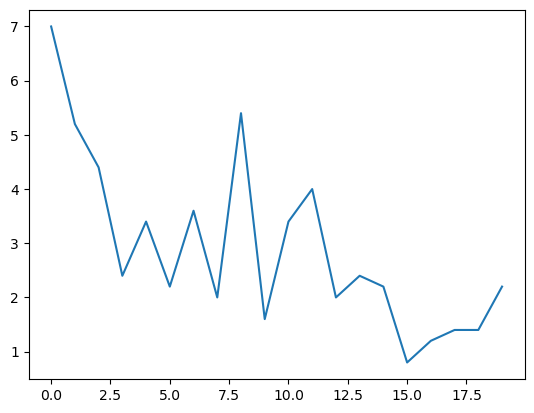

In [8]:
x = torch.tensor(step_counts, dtype=float).reshape(20, int(len(step_counts) / 20)).mean(1).numpy()
plt.plot(x)